# NLTK - Getting Started

NLTK or Natural Language Tool Kit is a python module that contains a number of resources for building natural language processing applications.

The toolkit comes with a number of existing text corpora that you can use for building and training models out of the box. It also comes with useful "lexical resource" datasets that can be used to augment and supplement your application.

This set of exercises are based on [chapter 1](http://www.nltk.org/book/ch01.html#sec-computing-with-language-texts-and-words) of the NLTK book.

## NLTK text resources

NLTK comes with a number of resoures. It is very easy to import them and use them to build NLP tools. Let's start by listing NLTK resources available to us.


In [2]:
from nltk.book import *
texts()

text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [3]:
#we can inspect the text items very easily
print(text1)

<Text: Moby Dick by Herman Melville 1851>


NLTK texts are stored in a way such that it is very easy to do some common NLP tasks on them.

## Concordance and similarity

The NLTK concordance function generates a list of all of the instances of a particular word in context, this allows you to see how the word is being used. Let's try this on the Moby Dick text.


In [8]:

text1.concordance("monstrous")

Displaying 11 of 11 matches:
ong the former , one was of a most monstrous size . ... This came towards us , 
ON OF THE PSALMS . " Touching that monstrous bulk of the whale or ork we have r
ll over with a heathenish array of monstrous clubs and spears . Some were thick
d as you gazed , and wondered what monstrous cannibal and savage could ever hav
that has survived the flood ; most monstrous and most mountainous ! That Himmal
they might scout at Moby Dick as a monstrous fable , or still worse and more de
th of Radney .'" CHAPTER 55 Of the Monstrous Pictures of Whales . I shall ere l
ing Scenes . In connexion with the monstrous pictures of whales , I am strongly
ere to enter upon those still more monstrous stories of them which are to be fo
ght have been rummaged out of this monstrous cabinet there is no telling . But 
of Whale - Bones ; for Whales of a monstrous size are oftentimes cast up dead u


We can see that monstrous is often used in the context of size and whales. I guess this is no surprise given the book we're reading.

Another function we can use here is the `similar()` function. This uses the context of the word to find words used in similar context. I.e. it looks for the words surrounding "monstrous" such as most _ size" or "the _ pictures" and tries to find other words that match.

In [9]:
text1.similar("monstrous")

candid subtly true puzzled maddens passing domineering abundant
reliable doleful untoward tyrannical curious determined part
lamentable lazy gamesome mouldy vexatious


Although perhaps a little tenuously related, these are all adjectives that do roughly fit the contexts described above.

We can also look at the other words used in the book and how frequently they are used.

## Frequency Distributions and NLTK

Earlier in this course we introduced the `collections.Counter` object which is like a special `dict` that counts occurrences of items in a list. NLTK provides an even more specialised version of this called `FreqDist` that also allows you to plot graphs.

Let's examine the words in Moby dick with a frequency dist.

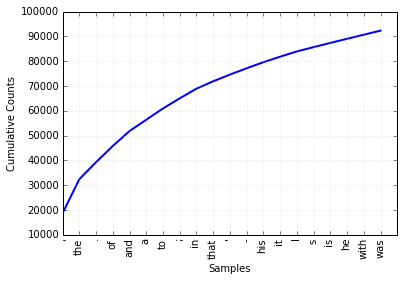

In [15]:
%matplotlib inline

f = FreqDist(text1)

f.plot(20, cumulative=True)

This is interesting but unfortunately a lot of the words that are being flagged up as the most frequent are commont words like 'the', 'of', 'and', 'to' and more. These are what we call `stopwords` - words common to almost all documents and as such, that provide no value to an analyst. We want to filter these out if we can. 

Thankfully NLTK comes with a stopwords list too. All we need to do is filter moby dick using this list.

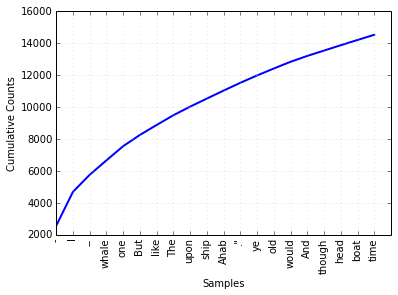

In [24]:
from nltk.corpus import stopwords as StopwordsLoader

stopwords = StopwordsLoader.words() + [':','?','!','"', "'", ';','.',',']

f = FreqDist([ x for x in text1 if x not in stopwords])

f.plot(20, cumulative=True)

This is much more interesting and informative. This plot really helps paint a picture of the plots and themes of the book. We are still seeing a number of words that are not descriptive. Let's introduce a rule that filters out words shorter than 5 characters long.

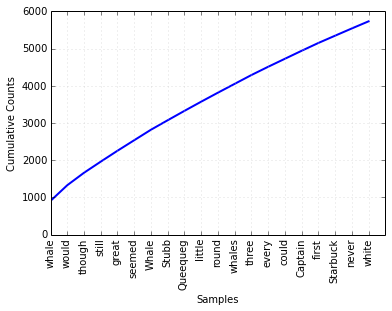

In [26]:
from nltk.corpus import stopwords as StopwordsLoader

stopwords = StopwordsLoader.words() + [':','?','!','"', "'", ';','.',',']

f = FreqDist([ x for x in text1 if (x not in stopwords and len(x) > 4)])

f.plot(20, cumulative=True)

## Collocations

Collocations are sequences of words that occur together more frequently than normal in a passage of text. For example "red wine" or "single mum" or "slim build". Often collocations describe well known phrases or idioms or are compound nouns. The NLTK book describes collocations as being resistant to substitution with words that have similar senses - e.g. maroon wine just doesn't seem the same as red wine.

We find collocations by identifying the most frequent bigrams in the text. Bigrams are just pairs of words that occur next to each other. Like the following

In [35]:
from nltk import bigrams

print (list(bigrams("hello my name is james and I am teaching you python".split(" "))))

[('hello', 'my'), ('my', 'name'), ('name', 'is'), ('is', 'james'), ('james', 'and'), ('and', 'I'), ('I', 'am'), ('am', 'teaching'), ('teaching', 'you'), ('you', 'python')]


NLTK has a built in collocations function that can be run on moby dick like so:

In [36]:
text1.collocations()

Sperm Whale; Moby Dick; White Whale; old man; Captain Ahab; sperm
whale; Right Whale; Captain Peleg; New Bedford; Cape Horn; cried Ahab;
years ago; lower jaw; never mind; Father Mapple; cried Stubb; chief
mate; white whale; ivory leg; one hand


In [ ]:
The collocations here are very specific to the book - Moby Dick. 